In [2]:
import pandahouse
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from read_db.CH import Getch

In [3]:
data = Getch(''' SELECT exp_group, 
                        user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21'
                        and exp_group in (1,2)
                GROUP BY exp_group, user_id
''').df

In [4]:
data.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [5]:
data.groupby('exp_group')['ctr'].mean()

exp_group
1    0.215605
2    0.214419
Name: ctr, dtype: float64

In [6]:
data.groupby('exp_group')['ctr'].median()

exp_group
1    0.203125
2    0.142857
Name: ctr, dtype: float64

Во второй группе средние и медианные значения CTR меньше, что уже ставит под сомнения разумность идеи раскатывания нового алгоритма на всех пользователей

In [7]:
sns.set(rc={'figure.figsize':(11,7)})

<AxesSubplot:xlabel='ctr', ylabel='Count'>

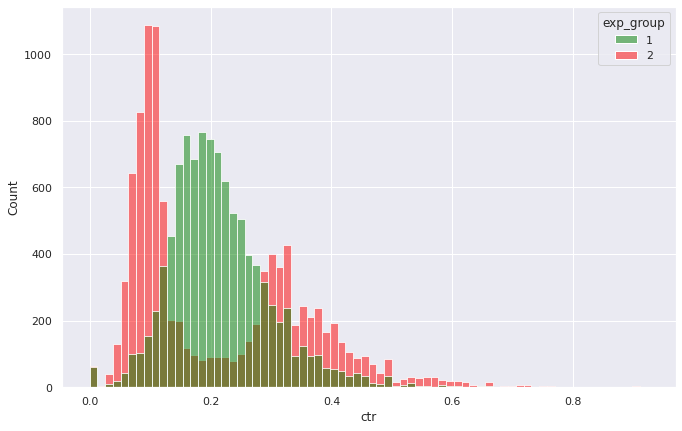

In [8]:
sns.histplot(data = data, 
              x='ctr', 
              hue='exp_group', 
              palette = ['green', 'red'],
              alpha=0.5,
              kde=False)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

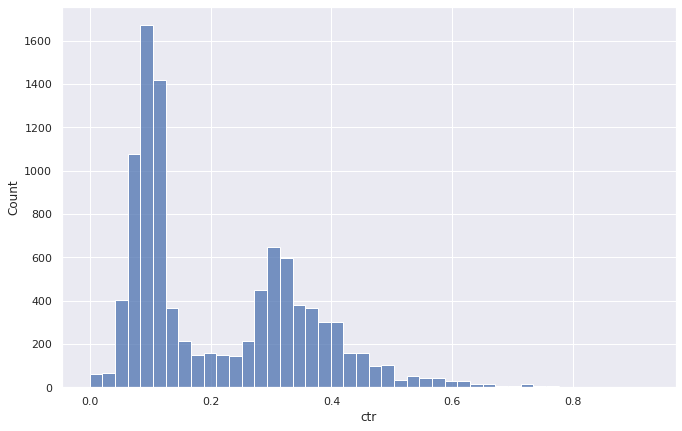

In [9]:
sns.histplot(data = data.query('exp_group == 2'), 
              x='ctr')

Распределение CTR у exp_group 2 ненормальное. Похоже, что образовались две группы

<AxesSubplot:xlabel='views', ylabel='Count'>

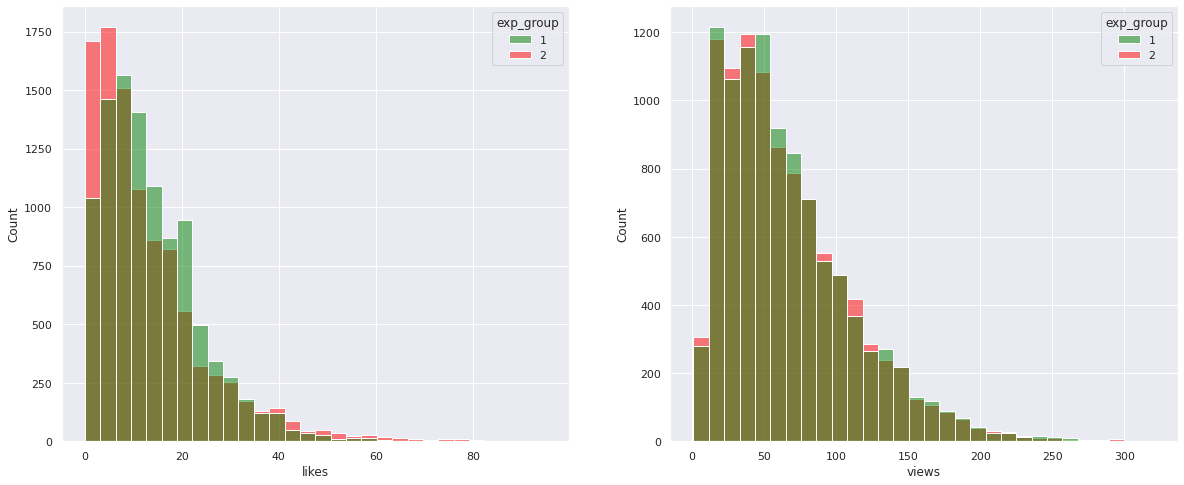

In [10]:
sns.set(rc={'figure.figsize':(20,8)})
f, axes = plt.subplots(1, 2)
sns.histplot(data = data, x='likes', hue='exp_group', palette = ['green', 'red'], alpha=0.5, kde=False, ax=axes[0], bins = 30)
sns.histplot(data = data, x='views', hue='exp_group', palette = ['green', 'red'], alpha=0.5, kde=False, ax=axes[1], bins = 30)

Распределение просмотров у группы 2 не отличается от группу 1, по лайкам есть заметные различия

In [11]:
likes_diff = data.query('exp_group == 2').groupby('likes')['user_id'].nunique() - data.query('exp_group == 1').groupby('likes')['user_id'].nunique()

In [12]:
likes_diff = likes_diff.dropna(inplace=False)

<AxesSubplot:xlabel='likes'>

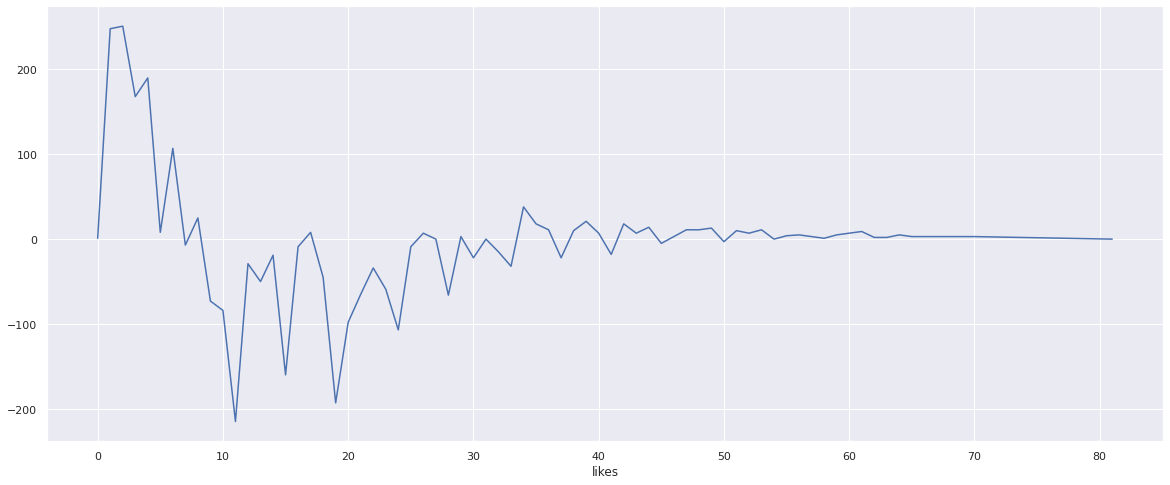

In [13]:
likes_diff.plot(use_index=True)

Как можно увидеть на графике, в группе 2 намного больше пользователей, которые поставили 1-2 лайка

In [14]:
ctr_diff = data.query('exp_group == 2').groupby('ctr')['user_id'].nunique() - data.query('exp_group == 1').groupby('ctr')['user_id'].nunique()

In [15]:
ctr_diff = ctr_diff.dropna(inplace=False)

<AxesSubplot:xlabel='ctr'>

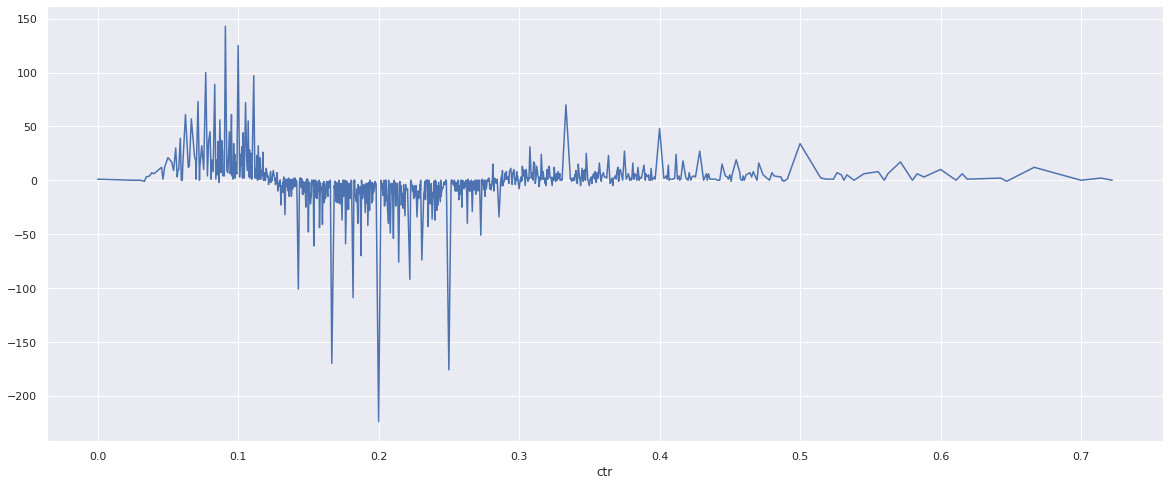

In [16]:
ctr_diff.plot(use_index=True)

Такая же картина наблюдается для разницы в CTR. В группе 2 большое количество пользователей с CTR до 0.1

Для начала попробуем **t-test на сглаженном CTR**

In [17]:
def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [18]:
global_ctr_1 = data.query('exp_group == 1').likes.sum()/data.query('exp_group == 1').views.sum()
global_ctr_2 = data.query('exp_group == 2').likes.sum()/data.query('exp_group == 2').views.sum()

In [19]:
global_ctr_1, global_ctr_2

(0.20802680490126244, 0.1980601844115994)

In [20]:
smoothed_ctr_1 = data.query('exp_group == 1').apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

smoothed_ctr_2 = data.query('exp_group == 2').apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [21]:
smoothed_ctr_1.mean(), smoothed_ctr_2.mean(), 

(0.21402549608884142, 0.21073955503259234)

In [22]:
stats.ttest_ind(smoothed_ctr_1, 
                smoothed_ctr_2,
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

Проведем также **тест Манна-Уитни** на тех же данных

In [23]:
stats.mannwhitneyu(smoothed_ctr_1, 
                   smoothed_ctr_2,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

Оба теста сработали на сглаженном CTR, p-value меньше 0.05, значит различия CTR в двух группах статистически значимы. Тест Манна-Уитни показал различия более явно, возможно, потому что распределение CTR в группе 2 ненормальное

Также проведем **тест Манна-Уитни поверх бакетного преобразования**

In [24]:
data_bucket = Getch(''' SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20220320.feed_actions 
    WHERE toDate(time) between '2022-03-15' and '2022-03-21'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
''').df

In [25]:
stats.mannwhitneyu(data_bucket.query('exp_group == 1').bucket_ctr, 
                   data_bucket.query('exp_group == 2').bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

P-value меньше 0.05. Проведем также **t-test** на этих же данных

In [26]:
stats.ttest_ind(data_bucket.query('exp_group == 1').bucket_ctr, 
                data_bucket.query('exp_group == 2').bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

**T-test** также показал, что различия статистически значимы

Все проведенные тесты показали статистически значимые различия в CTR для двух групп. Во второй группе, в которой был использован новый алгоритм, CTR (во всех вариациях - smoothed, global и т.д.) незначительно меньше, чем в первой. Очень похоже, что внутри группы 2, есть две подгруппы - одна, которой новый алгоритм понравился и вторая, которой алгоритм не зашел. По текущим данным я бы **не рекомендовал** раскатывать новый алгоритм на новых пользователей и подробнее бы изучил тестовую группу и попытался выяснить, каким пользователям алгоритм понравился, а каким нет  

**Сравниваем по возрасту**

In [27]:
data_age = Getch(''' SELECT exp_group, count(user_id) count, age
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21'
                      and exp_group in (1,2)
                GROUP BY exp_group, user_id, age
''').df

In [28]:
data_age.groupby('exp_group')['age'].mean()

exp_group
1    27.097331
2    27.235631
Name: age, dtype: float64

In [29]:
data_age.groupby('exp_group')['age'].std()

exp_group
1    10.129434
2    10.148552
Name: age, dtype: float64

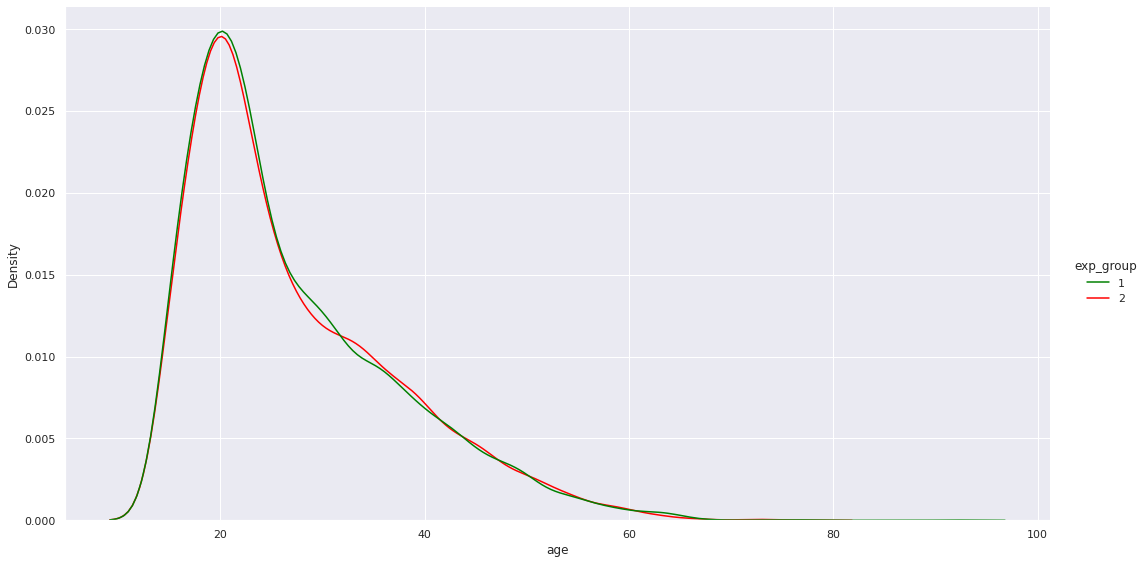

In [30]:
sns.displot(data=data_age, x="age", hue="exp_group", kind='kde', palette = ['green', 'red'], height=8, aspect=15/8)

Визуально по распределению возраста группа 2 не отличается от группы 1

**Сравниваем по OS**

In [31]:
data_os = Getch(''' SELECT exp_group, uniqExact(user_id) users, os
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21'
                      and exp_group in (1,2)
                GROUP BY exp_group, os
                order by os
''').df

In [32]:
data_os

,exp_group,users,os
0,2,6409,Android
1,1,6532,Android
2,1,3547,iOS
3,2,3543,iOS


**Сравниваем по Source**

In [33]:
data_source = Getch(''' SELECT exp_group, uniqExact(user_id) users, source
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21'
                      and exp_group in (1,2)
                GROUP BY exp_group, source
                order by source
''').df

In [34]:
data_source

,exp_group,users,source
0,1,4720,ads
1,2,4694,ads
2,2,5258,organic
3,1,5359,organic


**Сравниваем по Gender**

In [35]:
data_gender = Getch(''' SELECT exp_group, uniqExact(user_id) users, gender
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21'
                      and exp_group in (1,2)
                GROUP BY exp_group, gender
                order by gender
''').df

In [36]:
data_gender

,exp_group,users,gender
0,1,4535,0
1,2,4445,0
2,1,5544,1
3,2,5507,1


**Сравниваем по Country**

In [37]:
data_country = Getch(''' SELECT exp_group, uniqExact(user_id) users, country
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21'
                      and exp_group in (1,2)
                GROUP BY exp_group, country
                order by country, exp_group
''').df

In [38]:
data_country

,exp_group,users,country
0,1,90,Azerbaijan
1,2,110,Azerbaijan
2,1,212,Belarus
3,2,204,Belarus
4,1,8,Cyprus
5,2,12,Cyprus
6,1,18,Estonia
7,2,8,Estonia
8,1,98,Finland
9,2,108,Finland


Нет явных отличий в распределении по группам. Посмотрим на реакцию на новый алгоритм внутри группы 2

**Сравниваем внутри группы 2**

In [39]:
data_2 = Getch(''' SELECT os,
                        user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21' and exp_group == 2
                GROUP BY os, user_id
''').df

In [40]:
data_2.groupby('os')['ctr'].mean()

os
Android    0.216102
iOS        0.211376
Name: ctr, dtype: float64

In [41]:
data_2.groupby('os')['ctr'].median()

os
Android    0.145729
iOS        0.133803
Name: ctr, dtype: float64

In [42]:
global_ctr_ios = data_2.query('os == "iOS"').likes.sum()/data_2.query('os == "iOS"').views.sum()
global_ctr_and = data_2.query('os == "Android"').likes.sum()/data_2.query('os == "Android"').views.sum()

In [43]:
global_ctr_ios, global_ctr_and

(0.1936928373782819, 0.20051234004198343)

Сравним с данными по группе 2 до начала тестирования

In [44]:
data_os_comp = Getch(''' SELECT os,
                        user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions
                WHERE toDate(time) < '2022-03-15' and exp_group == 2
                GROUP BY os, user_id
''').df

In [45]:
data_os_comp.groupby('os')['ctr'].mean()

os
Android    0.214383
iOS        0.212942
Name: ctr, dtype: float64

В целом CTR у пользователей android и ios был примерно одинаковый, но в группе 2 CTR после обновления стал немного меньше у пользователей ios, возможно, им обновление понравилось меньше или оно работает не всегда корректно на iOS

In [46]:
data_2_age = Getch(''' SELECT multiIf(age <= 17, 'до 18', age > 17
                           and age <= 30, '18-30', age > 30
                           and age <= 50, '31-50', '50+') category_age,
                           user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21' and exp_group == 2
                GROUP BY category_age, user_id
''').df

In [47]:
data_2_age.groupby('category_age')['ctr'].mean()

category_age
18-30    0.211892
31-50    0.218530
50+      0.208421
до 18    0.217867
Name: ctr, dtype: float64

In [48]:
data_comp_age = Getch(''' SELECT multiIf(age <= 17, 'до 18', age > 17
                           and age <= 30, '18-30', age > 30
                           and age <= 50, '31-50', '50+') category_age,
                           user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) < '2022-03-15' and exp_group == 2
                GROUP BY category_age, user_id
''').df

In [49]:
data_comp_age.groupby('category_age')['ctr'].mean()

category_age
18-30    0.212883
31-50    0.215864
50+      0.211122
до 18    0.214717
Name: ctr, dtype: float64

In [50]:
data_2_age_2 = Getch(''' SELECT age,
                           user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21' and exp_group == 2
                GROUP BY age, user_id
''').df

In [51]:
age_graph = data_2_age_2.groupby('age')['ctr'].mean()

In [52]:
data_comp_age_2 = Getch(''' SELECT age,
                           user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) < '2022-03-15' and exp_group == 2
                GROUP BY age, user_id
''').df

In [53]:
age_graph_comp = data_comp_age_2.groupby('age')['ctr'].mean()

<AxesSubplot:xlabel='age'>

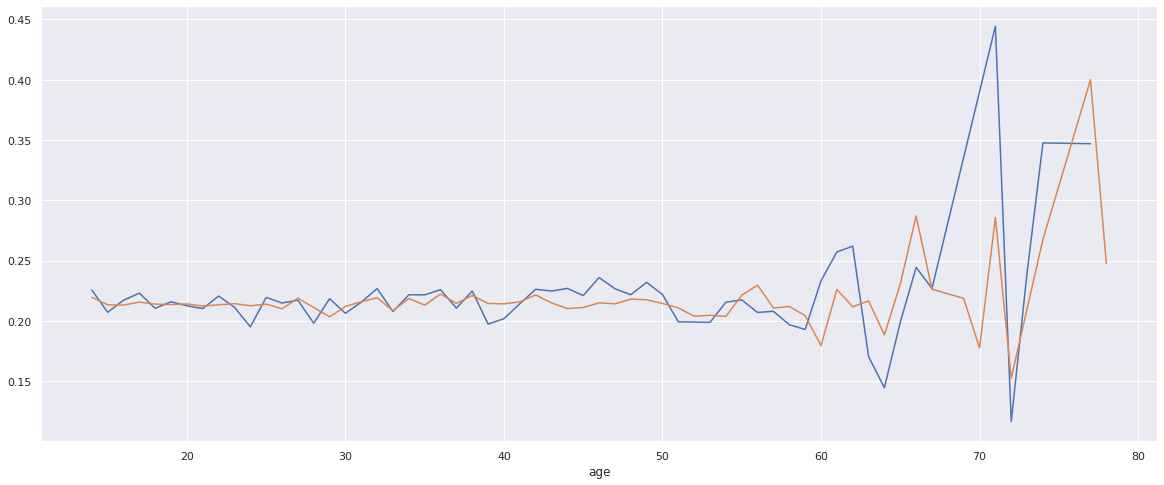

In [54]:
fig, ax = plt.subplots()
age_graph.plot(use_index=True)
age_graph_comp.plot(use_index=True)

Заметных различий в CTR для различных возрастных групп до и после теста нет

In [55]:
data_2_country = Getch(''' SELECT country,
                           user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21' and exp_group == 2
                GROUP BY country, user_id
''').df

In [56]:
data_2_country.groupby('country')['ctr'].mean()

country
Azerbaijan     0.225333
Belarus        0.197325
Cyprus         0.296588
Estonia        0.227662
Finland        0.199538
Kazakhstan     0.212034
Latvia         0.198437
Russia         0.214938
Switzerland    0.182993
Turkey         0.207754
Ukraine        0.213821
Name: ctr, dtype: float64

In [57]:
data_comp_country = Getch(''' SELECT country,
                           user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions
                WHERE toDate(time) < '2022-03-15' and exp_group == 2
                GROUP BY country, user_id
''').df

In [58]:
data_comp_country.groupby('country')['ctr'].mean()

country
Azerbaijan     0.229264
Belarus        0.208267
Cyprus         0.228728
Estonia        0.224734
Finland        0.220596
Kazakhstan     0.212772
Latvia         0.185692
Russia         0.213722
Switzerland    0.206203
Turkey         0.224025
Ukraine        0.213061
Name: ctr, dtype: float64

<AxesSubplot:ylabel='country'>

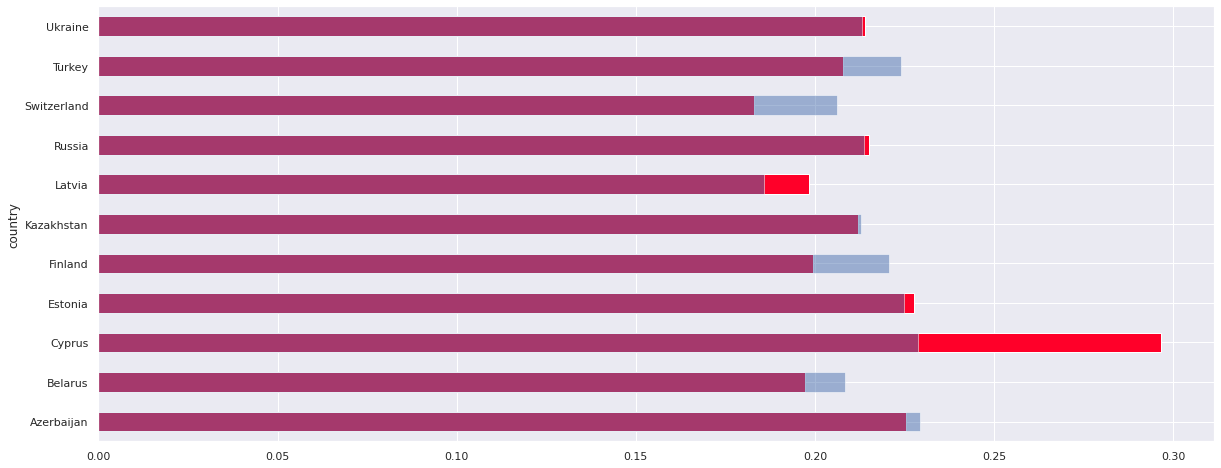

In [59]:
country_graph = data_2_country.groupby('country')['ctr'].mean()
country_graph_comp = data_comp_country.groupby('country')['ctr'].mean()
fig, ax = plt.subplots()
country_graph.plot(kind="barh", colormap = 'gist_rainbow', use_index=True)
country_graph_comp.plot(kind="barh", use_index=True, alpha=0.5)

In [60]:
data_comp_country.groupby('country')['user_id'].count()

country
Azerbaijan      105
Belarus         199
Cyprus           11
Estonia           7
Finland         111
Kazakhstan      200
Latvia           12
Russia         8995
Switzerland       9
Turkey           94
Ukraine         491
Name: user_id, dtype: int64

Заметные различия только для пользователей с Кипра, но из-за того что их очень мало, эти различия не стоит принимать в счет

In [61]:
data_2_source= Getch(''' SELECT source,
                           user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21' and exp_group == 2
                GROUP BY source, user_id
''').df

data_comp_source = Getch(''' SELECT source,
                           user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions
                WHERE toDate(time) < '2022-03-15' and exp_group == 2
                GROUP BY source, user_id
''').df

In [62]:
data_2_source.groupby('source')['ctr'].mean()

source
ads        0.215589
organic    0.213375
Name: ctr, dtype: float64

In [63]:
data_comp_source.groupby('source')['ctr'].mean()

source
ads        0.215035
organic    0.212668
Name: ctr, dtype: float64

In [64]:
data_2_gender= Getch(''' SELECT gender,
                           user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21' and exp_group == 2
                GROUP BY gender, user_id
''').df

data_comp_gender = Getch(''' SELECT gender,
                           user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions
                WHERE toDate(time) < '2022-03-15' and exp_group == 2
                GROUP BY gender, user_id
''').df

In [65]:
data_2_gender.groupby('gender')['ctr'].mean()

gender
0    0.215626
1    0.213445
Name: ctr, dtype: float64

In [66]:
data_comp_gender.groupby('gender')['ctr'].mean()

gender
0    0.213458
1    0.214206
Name: ctr, dtype: float64

Женщинам новый алгоритм понравилось немного меньше, но различия незначительные

Изучим подробнее различия в CTR для пользователей различных устройств

<AxesSubplot:xlabel='ctr', ylabel='Count'>

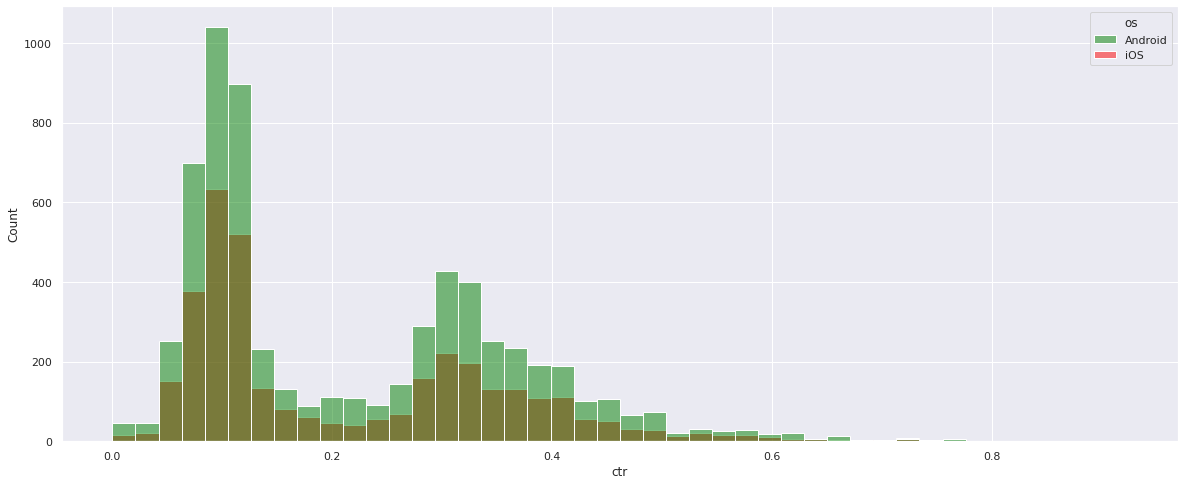

In [67]:
sns.histplot(data = data_2, 
              x='ctr', 
              hue='os', 
              palette = ['green', 'red'],
              alpha=0.5,
              kde=False)

In [68]:
p_values = []
for i in range(10000):
    iOS = data_2[data_2.os == 'iOS'].ctr.sample(500, replace=True)
    andr = data_2[data_2.os == 'Android'].ctr.sample(500, replace=True)
    p_values.append(stats.mannwhitneyu(iOS, andr, alternative = 'two-sided')[1])

In [69]:
sum(p_values)/len(p_values)

0.4578833893468245

In [70]:
data_2.groupby('os')['ctr'].std()

os
Android    0.144144
iOS        0.144216
Name: ctr, dtype: float64

Статистически значимых различий в CTR для пользователей iOS и Android нет, значит это не могло повлиять на разделение по группам

Посмотрим когда зарегистрировались пользователи, попавшие в группу 2. Предположим, что старым пользователям новый алгоритм не понравился

In [71]:
data_reg_2= Getch(''' SELECT t1.user_id, toString(t1.start_week) start_week, round(t2.ctr, 4) ctr
FROM
(SELECT user_id,
min(toWeek(time)) AS start_week
FROM simulator_20220320.feed_actions
where user_id in
(SELECT distinct user_id
FROM simulator_20220320.feed_actions 
WHERE toDate(time) between '2022-03-15' and '2022-03-21' and exp_group == 2)
group by user_id) t1
JOIN 
(SELECT user_id,
sum(action = 'like') likes,
sum(action = 'view') views,
likes/views ctr
FROM simulator_20220320.feed_actions 
WHERE toDate(time) between '2022-03-15' and '2022-03-21' and exp_group == 2
GROUP BY user_id) t2
USING user_id
''').df

In [72]:
df_reg = data_reg_2.groupby('start_week')['ctr'].mean().to_frame().reset_index().sort_values('ctr')

In [73]:
df_reg

,start_week,ctr
0,10,0.205607
1,11,0.208306
2,12,0.217134
5,9,0.219085
4,8,0.224988
3,7,0.226536


[(0.2, 0.23)]

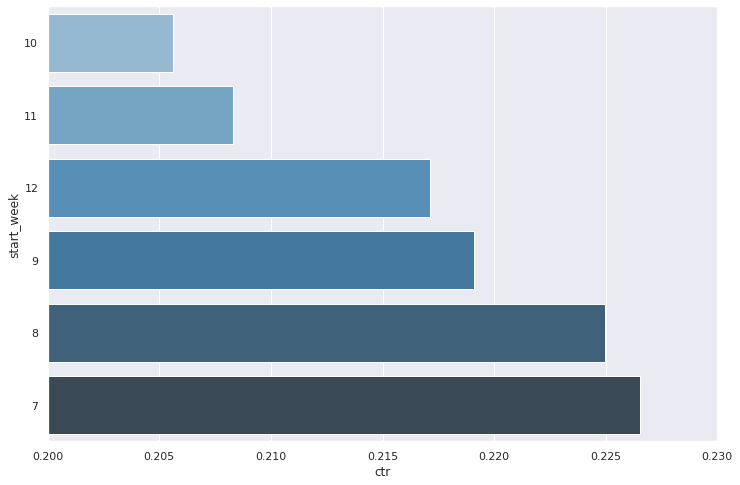

In [74]:
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.barplot(x="ctr", y="start_week", data=df_reg, palette="Blues_d")
ax.set(xlim=(0.2, 0.23))

In [75]:
df_reg_count = data_reg_2.groupby('start_week')['user_id'].count().to_frame().reset_index().sort_values('user_id')

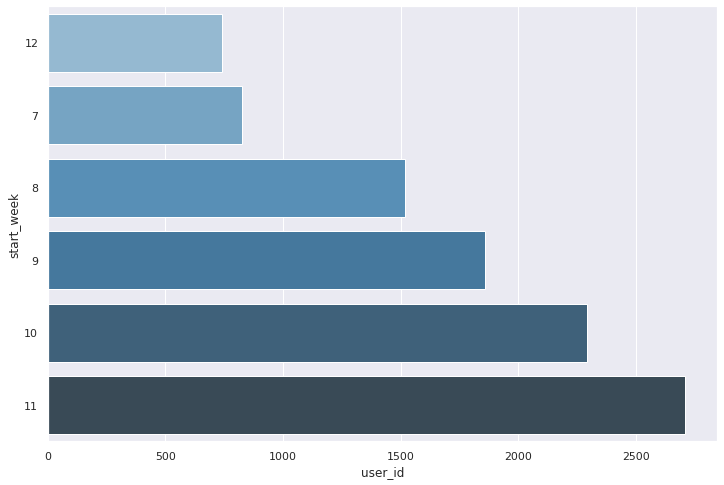

In [76]:
ax = sns.barplot(x="user_id", y="start_week", data=df_reg_count, palette="Blues_d")

<AxesSubplot:xlabel='ctr', ylabel='Count'>

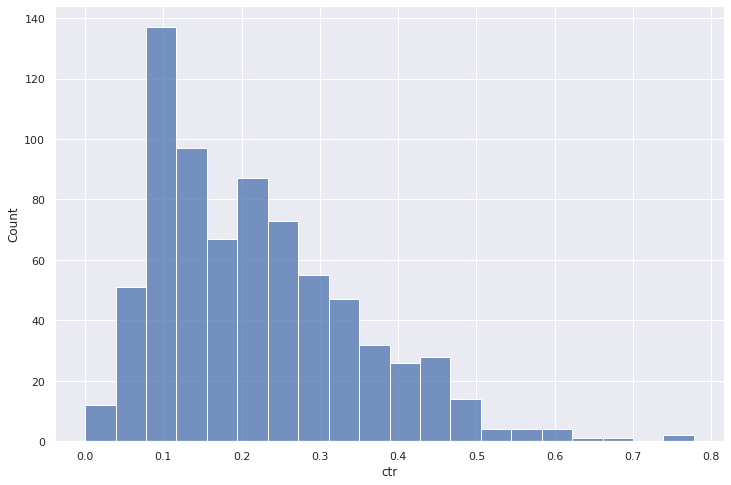

In [77]:
data_reg_2_12 = data_reg_2.query('start_week == "12"')
sns.histplot(data_reg_2_12, x='ctr', kde=False)

<AxesSubplot:xlabel='ctr', ylabel='Density'>

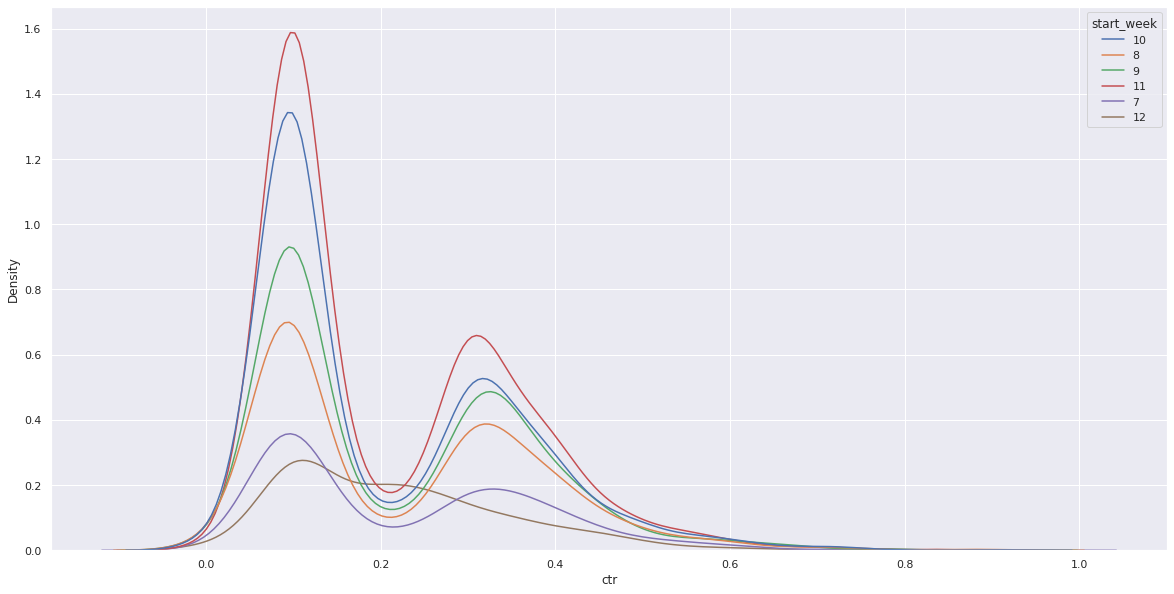

In [78]:
sns.set(rc={'figure.figsize':(20,10)})
sns.kdeplot(data=data_reg_2, x="ctr", hue="start_week", multiple="layer" )

In [79]:
p_values = []
for i in range(1000):
                   p_values.append(stats.mannwhitneyu(data_reg_2.query('start_week == "12"').ctr.sample(500, replace=True), 
                   data_reg_2.query('start_week == "11"').ctr.sample(500, replace=True), 
                   alternative = 'two-sided')[1])
mean = round(sum(p_values)/len(p_values), 4)                  
print('P-value для недели 12 и 11', mean)

P-value для недели 12 и 11 0.1032


In [80]:
p_values = []
for i in range(1000):
                   p_values.append(stats.mannwhitneyu(data_reg_2.query('start_week == "12"').ctr.sample(500, replace=True), 
                   data_reg_2.query('start_week == "10"').ctr.sample(500, replace=True), 
                   alternative = 'two-sided')[1])
mean = round(sum(p_values)/len(p_values), 4)                  
print('P-value для недели 12 и 10', mean)

P-value для недели 12 и 10 0.0328


In [81]:
p_values = []
for i in range(1000):
                   p_values.append(stats.mannwhitneyu(data_reg_2.query('start_week == "12"').ctr.sample(500, replace=True), 
                   data_reg_2.query('start_week == "9"').ctr.sample(500, replace=True), 
                   alternative = 'two-sided')[1])
mean = round(sum(p_values)/len(p_values), 4)                  
print('P-value для недели 12 и 9', mean)

P-value для недели 12 и 9 0.3455


In [82]:
p_values = []
for i in range(1000):
                   p_values.append(stats.mannwhitneyu(data_reg_2.query('start_week == "12"').ctr.sample(500, replace=True), 
                   data_reg_2.query('start_week == "8"').ctr.sample(500, replace=True), 
                   alternative = 'two-sided')[1])
mean = round(sum(p_values)/len(p_values), 4)                  
print('P-value для недели 12 и 8', mean)

P-value для недели 12 и 8 0.4298


In [83]:
p_values = []
for i in range(1000):
                   p_values.append(stats.mannwhitneyu(data_reg_2.query('start_week == "12"').ctr.sample(500, replace=True), 
                   data_reg_2.query('start_week == "7"').ctr.sample(500, replace=True), 
                   alternative = 'two-sided')[1])
mean = round(sum(p_values)/len(p_values), 4)                  
print('P-value для недели 12 и 7', mean)

P-value для недели 12 и 7 0.4724


<code> По результатам анализа пользователей по дате регистрации(первого действия) можно сделать следующие выводы:
    - пользователи, которые зарегистрировались за несколько дней до тестирования, отреагировали на новой алгоритм более менее одинаково и у них нет такого разброса по CTR, как у пользователей, которые зарегистрировались раньше. Возможно, это обусловлено тем, что они еще не успели привыкнуть к старому алогоритму и новый алгоритм рекомендаций не вызвал у них такую неоднозначную реакцию;  
    - пользователи, которые зарегестрировались за 1-2 недели до теста, отреагировали на новый алгоритм более негативно и наиболее явно разделились на две группы - те, кому новый алгоритм понравился и те, кому нет. Возможно, более низкий CTR связан с тем, что пользователи только привыкли к интерфейсу соцсети, а тут уже пришлось приспосабливаться к новому алгоритму;
    - пользователи, которые уже давно пользуются соцсетью также отреагировали неодзнозначно на новый алгоритм, но при этом CTR у них в среднем на 2-3 процента выше, чем у тех пользователей, которые пришли недавно. Возможно, из-за того, что они уже давно пользуются платформой, они реагируют на нововведения более лояльно.
</code>

## **Рекомендация**:
### Я бы рекомендовал продлить тестирование еще на 1-2 недели, чтобы получить больше данных. Также, возможно, за это время у пользователей сформируется более однозначная реакция. Помимо этого, часто пользователи в первое время негативно реагируют на нововведения и нужно больше времени, чтобы оценить насколько новый им больше подходит


In [111]:
data_time = Getch(''' SELECT toDate(time) time,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21'
                        and exp_group = '2'
                GROUP BY time
''').df

In [121]:
data_time_1 = Getch(''' SELECT toDate(time) time,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21'
                        and exp_group = '1'
                GROUP BY time
''').df

<AxesSubplot:xlabel='time'>

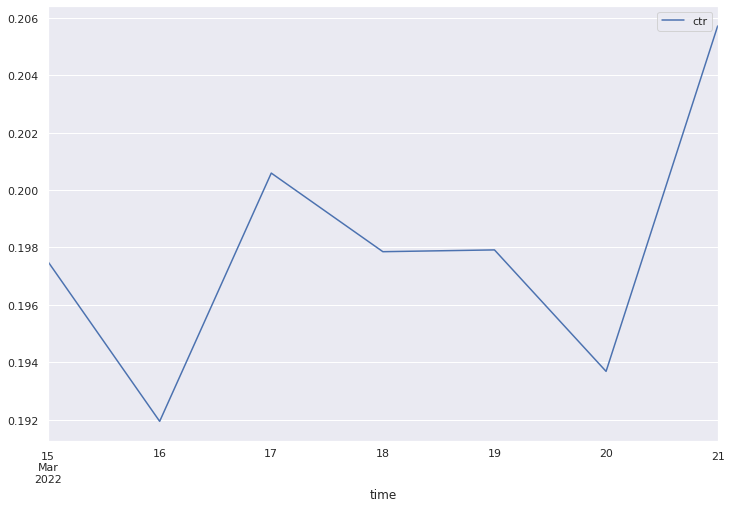

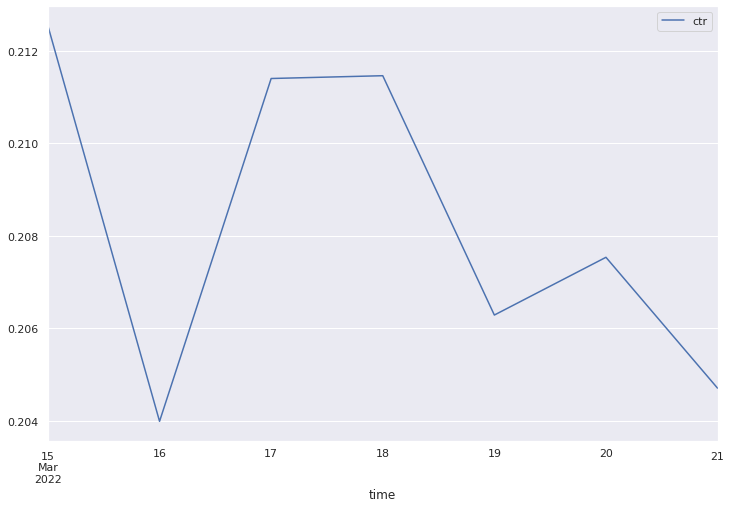

In [120]:
data_time.plot(x='time', y='ctr', xlabel='time', figsize=(12, 8))
data_time_1.plot(x='time', y='ctr', xlabel='time', figsize=(12, 8))

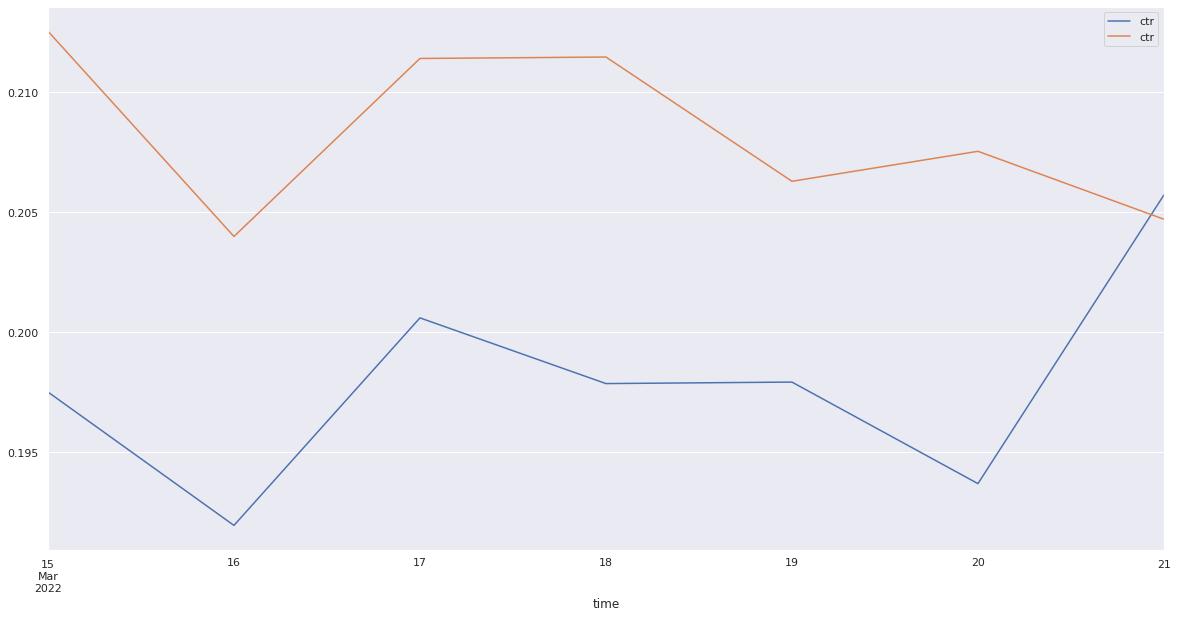

In [128]:
firstPlot = data_time.plot(x='time', y='ctr') 
data_time_1.plot(x='time', y='ctr', ax=firstPlot)
plt.show()

##### Как мы можем видеть на графике CTR у тестовой группы постепенно становится больше и в последний день тестирования даже становится больше, чем у контрольной группы. Это еще раз подтверждает, что **тестированию нужно продолжить** и посмотреть, как измениться CTR через некоторое время